## Немного безумия

смотрим, работают ли attention models

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt

In [2]:
import numpy
import root_numpy
# import pandas - no pandas today 
from astropy.table import Table
from sklearn.metrics import roc_auc_score
from scipy.special import logit

In [3]:
# theano imports
import theano
from theano import tensor as T
from theano.tensor.nnet import softplus
from theano.tensor.extra_ops import bincount

In [4]:
features = [
    # track itself
    'eta', 'partPt', 'partP',
    # track and B
    'cos_diff_phi', 'proj', 'diff_eta', 'ptB', 'R_separation', 'proj_T', 'proj_T2',
    # PID
    'PIDNNe',  'PIDNNk',  'PIDNNm', 'ghostProb', 
    # IP
    'IP', 'IPerr', 'IPs', 'IPPU', 
    # Other
    'veloch', 'partlcs', 'EOverP', 
    # deleted as probably inappropriate:
    # 'phi',  
    # 'diff_pt', 'nnkrec',
    # 'max_PID_mu_e', 'max_PID_mu_k', 'sum_PID_k_e', 'sum_PID_mu_e', 'max_PID_k_e', 'sum_PID_mu_k', 
]

In [5]:
# data = Table(root_numpy.root2array('../datasets/MC/csv/WG/Bu_JPsiK/2012/Tracks.root', stop=3000))
data = Table(root_numpy.root2array('../datasets/MC/csv/WG/Bu_JPsiK/2012/Tracks.root', stop=30000000))

data['label'] = (data['signB'] * data['signTrack']) > 0

data['cos_diff_phi'] = numpy.cos(data['diff_phi'])
data['diff_pt'] = data['ptB'] - data['partPt']
data['R_separation'] = numpy.sqrt(data['diff_eta'] ** 2 + (1 - data['cos_diff_phi']) ** 2)
# projection in transverse plane
data['proj_T'] = data['cos_diff_phi'] * data['partPt']
data['proj_T2'] = data['cos_diff_phi'] * data['partPt'] * data['ptB']

data = data[data['ghostProb'] < 0.4]
data = data[numpy.isfinite(data['IPs'])]

In [6]:
groups = data['run'] + data['event'].astype(int) * (data['run'].max() + 1)
_, data['group_column'] = numpy.unique(groups, return_inverse=True)
data = data.group_by('group_column')

In [7]:
import sys
sys.path.insert(0, '../')

## Вспомогательные функции

In [8]:
def compute_weights(data, attention):
    """
    Weights are normalized over events. Higher convenience - higher weights
    """
    assert len(numpy.shape(attention)) == 1
    weights = numpy.exp(attention)
    sum_weights = numpy.bincount(data['group_column'], weights=weights)
    return weights / (sum_weights[data['group_column']] + 1)

In [9]:
def compute_auc_with_attention(data, track_proba, track_attention):
    assert track_proba.shape == (len(data), 2)
    assert len(track_attention) == len(data)
    tracks_weights = compute_weights(data, track_attention)
    event_predictions = numpy.bincount(
        data['group_column'], weights=logit(track_proba[:, 1]) * data['signTrack'] * tracks_weights)
    B_signs = data['signB'].group_by(data['group_column']).groups.aggregate(numpy.mean)
    return roc_auc_score(B_signs, event_predictions)

## Просто поезд + inclusive

In [10]:
from folding_group import FoldingGroupClassifier
from decisiontrain import DecisionTrainClassifier

/mnt/mfs/miniconda/envs/rep_py2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [11]:
base_clf = DecisionTrainClassifier(n_estimators=1000, learning_rate=0.03, n_threads=len(features), 
                                   train_features=features, max_features=0.9)

In [12]:
%%time
dt = FoldingGroupClassifier(base_clf, n_folds=2, group_feature='group_column')
_ = dt.fit(data[features + ['group_column']].to_pandas(), data['label'])

CPU times: user 45min 53s, sys: 8min 24s, total: 54min 18s
Wall time: 8min 20s


In [13]:
# raw quality
B_signs = data['signB'].group_by(data['group_column']).groups.aggregate(numpy.mean)
track_proba = dt.predict_proba(data.to_pandas())
predictions = numpy.bincount(data['group_column'], weights=logit(track_proba[:, 1]) * data['signTrack'])
roc_auc_score(B_signs, predictions)

KFold prediction using folds column


0.66057126874375682

In [14]:
compute_auc_with_attention(data, 
                           track_proba=dt.predict_proba(data.to_pandas()), 
                           track_attention=numpy.zeros(len(data)) - 2)

KFold prediction using folds column


0.66281719228620928

In [15]:
compute_auc_with_attention(data, 
                           track_proba=dt.predict_proba(data.to_pandas()), 
                           track_attention=numpy.zeros(len(data)) - 2)

KFold prediction using folds column


0.66281719228620928

In [16]:
%%time
_n_tracks = numpy.bincount(data['group_column'])[data['group_column']] 
_weights = (_n_tracks > 5) & (_n_tracks < 40)
dt_on_filtered = FoldingGroupClassifier(base_clf, n_folds=2, group_feature='group_column')
_ = dt_on_filtered.fit(data[features + ['group_column']].to_pandas(), data['label'], sample_weight=_weights)

CPU times: user 47min 23s, sys: 9min 8s, total: 56min 31s
Wall time: 9min 24s


In [17]:
# on filtered dataset
compute_auc_with_attention(data, 
                           track_proba=dt_on_filtered.predict_proba(data.to_pandas()),
                           track_attention=numpy.zeros(len(data)) - 2)

KFold prediction using folds column


0.66283443034982881

In [18]:
sorted(zip(dt.estimators[0].feature_importances_ + dt.estimators[1].feature_importances_, features))

[(0.010999999999999999, 'eta'),
 (0.010999999999999999, 'partlcs'),
 (0.035000000000000003, 'diff_eta'),
 (0.037000000000000005, 'proj_T2'),
 (0.037999999999999999, 'cos_diff_phi'),
 (0.037999999999999999, 'ptB'),
 (0.044999999999999998, 'IPerr'),
 (0.047, 'veloch'),
 (0.055999999999999994, 'EOverP'),
 (0.056000000000000001, 'ghostProb'),
 (0.059999999999999998, 'IPPU'),
 (0.066000000000000003, 'partP'),
 (0.072000000000000008, 'proj_T'),
 (0.08299999999999999, 'R_separation'),
 (0.109, 'PIDNNe'),
 (0.13800000000000001, 'PIDNNm'),
 (0.189, 'IP'),
 (0.20499999999999999, 'IPs'),
 (0.215, 'proj'),
 (0.23399999999999999, 'PIDNNk'),
 (0.255, 'partPt')]

In [19]:
sorted(zip(dt.estimators[0].feature_importances_ + dt.estimators[1].feature_importances_, features))

[(0.010999999999999999, 'eta'),
 (0.010999999999999999, 'partlcs'),
 (0.035000000000000003, 'diff_eta'),
 (0.037000000000000005, 'proj_T2'),
 (0.037999999999999999, 'cos_diff_phi'),
 (0.037999999999999999, 'ptB'),
 (0.044999999999999998, 'IPerr'),
 (0.047, 'veloch'),
 (0.055999999999999994, 'EOverP'),
 (0.056000000000000001, 'ghostProb'),
 (0.059999999999999998, 'IPPU'),
 (0.066000000000000003, 'partP'),
 (0.072000000000000008, 'proj_T'),
 (0.08299999999999999, 'R_separation'),
 (0.109, 'PIDNNe'),
 (0.13800000000000001, 'PIDNNm'),
 (0.189, 'IP'),
 (0.20499999999999999, 'IPs'),
 (0.215, 'proj'),
 (0.23399999999999999, 'PIDNNk'),
 (0.255, 'partPt')]

# Длинный поезд

In [20]:
long_dt = FoldingGroupClassifier(
    DecisionTrainClassifier(n_estimators=3000, learning_rate=0.02, max_features=0.9,
                            n_threads=len(features), train_features=features), 
    n_folds=2, group_feature='group_column')

In [21]:
_ = long_dt.fit(data[features + ['group_column']].to_pandas(), 
                data['label'], 
                sample_weight=compute_weights(data, numpy.zeros(len(data)) - 2.))

In [22]:
for i, p in enumerate(long_dt.staged_predict_proba(data.to_pandas()), 1):
    if i % 5 == 0:
        print compute_auc_with_attention(data, track_proba=p, track_attention=numpy.zeros(len(data)) - 2.)

KFold prediction using folds column
0.649884278779
0.660581502153
0.662401725219
0.663233151088
0.663442556187
0.663394922291


## Если просто взвесить обучающую выборку

то есть отнормировать веса треков внутри одного события, получаем существенный прирост, если их использовать во время предсказания.

При этом использование весов в тренировке - это странно

In [23]:
weights = compute_weights(data, attention=numpy.zeros(len(data)))

In [24]:
dt_simpleweights = FoldingGroupClassifier(base_clf, n_folds=2, group_feature='group_column')
dt_simpleweights.fit(data[features + ['group_column']].to_pandas(), data['label'], sample_weight=weights);

In [25]:
compute_auc_with_attention(data, 
                           track_proba=dt_simpleweights.predict_proba(data.to_pandas()), 
                           track_attention=numpy.zeros(len(data)))

KFold prediction using folds column


0.66260082020698474

## Посмотрим на качество в зависимости от числа треков

In [26]:
n_tracks = numpy.bincount(data['group_column'])

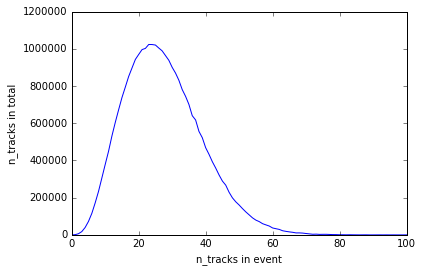

In [27]:
plt.plot(numpy.bincount(n_tracks) * numpy.arange(max(n_tracks) + 1))
plt.xlabel('n_tracks in event')
plt.ylabel('n_tracks in total')

In [28]:
# plt.plot(* zip(*(
#         [i, roc_auc_score(B_signs[n_tracks == i], predictions[n_tracks == i])]
#         for i in range(2, 60)
# )))

# Попытаемся отличить правильно предсказанные.

In [29]:
correctness = logit(track_proba[:, 1]) * (2 * data['label'] - 1)

In [30]:
for percentile in [50, 60, 70, 80]:
    dt_attention = FoldingGroupClassifier(base_clf, n_folds=2, group_feature='group_column')
    dt_attention.fit(data[features + ['group_column']].to_pandas(), 
                     correctness > numpy.percentile(correctness, percentile))

    attention = logit(dt_attention.predict_proba(data[features + ['group_column']].to_pandas())[:, 1])
    if percentile == 70:
        stable_attention = attention.copy()
    attention_weights = compute_weights(data, attention)

    dt_classifier = FoldingGroupClassifier(base_clf, n_folds=2, group_feature='group_column')
    dt_classifier.fit(data[features + ['group_column']].to_pandas(), 
                      data['label'], sample_weight=attention_weights)

    print percentile, compute_auc_with_attention(data, dt_classifier.predict_proba(data.to_pandas()), attention)

KFold prediction using folds column
50 KFold prediction using folds column
0.661690653583
KFold prediction using folds column
60 KFold prediction using folds column
0.662061552908
KFold prediction using folds column
70 KFold prediction using folds column
0.660748379403
KFold prediction using folds column
80 KFold prediction using folds column
0.658654955968


## Дополнительная проверка верности корректировки веса
пробуем, работает ли линейная корректировка веса.

Да, при этом сдвиг является важным, то есть наличие нормализации порядка $e^2$

In [31]:
_proba = dt.predict_proba(data.to_pandas())
for alpha in [-3, -2, -1, 0]:
    for beta in numpy.linspace(0.5, 1.2, 5):
        print alpha, '\t', beta, '\t', compute_auc_with_attention(data, _proba, alpha + beta * stable_attention)

KFold prediction using folds column
-3 	0.5 	0.661327839454
-3 	0.675 	0.660745030809
-3 	0.85 	0.660142538988
-3 	1.025 	0.659531619479
-3 	1.2 	0.658919313248
-2 	0.5 	0.661714029974
-2 	0.675 	0.661178247078
-2 	0.85 	0.660612026943
-2 	1.025 	0.660030440896
-2 	1.2 	0.65944330229
-1 	0.5 	0.661618636182
-1 	0.675 	0.661125887542
-1 	0.85 	0.660594533625
-1 	1.025 	0.660042541154
-1 	1.2 	0.659482073589
0 	0.5 	0.661381131178
0 	0.675 	0.660903309288
0 	0.85 	0.660383418451
0 	1.025 	0.659840838786
0 	1.2 	0.659288848443


## Дополнительная  проверка 
того, что взаимное обучение attention и классификатора работает. 


In [32]:
# lazy start
_attention = numpy.zeros(len(data))
_correctness = numpy.zeros(len(data))

for iteration in range(5):
    dt_classifier = FoldingGroupClassifier(base_clf, n_folds=2, group_feature='group_column')
    dt_classifier.fit(data[features + ['group_column']].to_pandas(),
                      data['label'], sample_weight=compute_weights(data, _attention))
    
    _correctness = logit(dt_classifier.predict_proba(data.to_pandas())[:, 1]) * (2 * data['label'] - 1)
    
    print compute_auc_with_attention(data, dt_classifier.predict_proba(data.to_pandas()), _attention)
    
    dt_attention = FoldingGroupClassifier(base_clf, n_folds=2, group_feature='group_column')
    dt_attention.fit(data[features + ['group_column']].to_pandas(),
                     _correctness > numpy.percentile(_correctness, 70))
    
    _attention = logit(dt_attention.predict_proba(data.to_pandas())[:, 1])
    
    print compute_auc_with_attention(data, dt_classifier.predict_proba(data.to_pandas()), _attention)

KFold prediction using folds column
KFold prediction using folds column
0.662609360691
KFold prediction using folds column
KFold prediction using folds column
0.660602583854
KFold prediction using folds column
KFold prediction using folds column
0.660905334811
KFold prediction using folds column
KFold prediction using folds column
0.660813626497
KFold prediction using folds column
KFold prediction using folds column
0.660784447699
KFold prediction using folds column
KFold prediction using folds column
0.660819333451
KFold prediction using folds column
KFold prediction using folds column
0.660824832463
KFold prediction using folds column
KFold prediction using folds column
0.660780437217
KFold prediction using folds column
KFold prediction using folds column
0.660655642292
KFold prediction using folds column
KFold prediction using folds column
0.660558555326


## Дополнительная проверка 
что обучение с приоритезацией работает. Оставялем везде по два-три трека

- не работает

In [33]:
# TODO fast orders
# from astropy.table import Column

# def compute_orders(indices, predictions):
#     '''less is better'''
#     assert len(indices) == len(predictions)
#     result = numpy.zeros(len(predictions))
#     for index in numpy.unique(indices):
#         result[indices == index] = numpy.argsort(numpy.argsort( - predictions[indices == index]))
#     return result
        

In [34]:
# orders = compute_orders(data['group_column'], correctness)

In [35]:
# for percentile in [60, 70, 80]:
#     for n_tracks in [3, 5, 7]:
#         # lazy start
#         _attention = numpy.zeros(len(data))

#         dt_classifier = FoldingGroupClassifier(base_clf, n_folds=2, group_feature='group_column')
#         dt_classifier.fit(data[features + ['group_column']].to_pandas(),
#                           data['label'], sample_weight=compute_weights(data, _attention))

#         _correctness = logit(dt_classifier.predict_proba(data.to_pandas())[:, 1]) * (2 * data['label'] - 1)

#         dt_attention = FoldingGroupClassifier(base_clf, n_folds=2, group_feature='group_column')
#         dt_attention.fit(data[features + ['group_column']].to_pandas(),
#                          (_correctness > numpy.percentile(_correctness, percentile)) * (orders < n_tracks) )

#         _attention = logit(dt_attention.predict_proba(data.to_pandas())[:, 1])

#         print n_tracks, '\t', percentile, '\t', \
#             compute_auc_with_attention(data, dt_classifier.predict_proba(data.to_pandas()), _attention)

## Небольшое сравнение importance для моделей attention и classifier

In [36]:
sorted(zip(dt_classifier.estimators[0].feature_importances_, features))

[(0.0030000000000000001, 'eta'),
 (0.0030000000000000001, 'partlcs'),
 (0.0070000000000000001, 'diff_eta'),
 (0.014999999999999999, 'proj_T2'),
 (0.017999999999999999, 'cos_diff_phi'),
 (0.02, 'IPPU'),
 (0.021000000000000001, 'veloch'),
 (0.023, 'EOverP'),
 (0.023, 'ghostProb'),
 (0.023, 'ptB'),
 (0.029000000000000001, 'IPerr'),
 (0.029000000000000001, 'partP'),
 (0.043999999999999997, 'proj_T'),
 (0.044999999999999998, 'R_separation'),
 (0.049000000000000002, 'PIDNNe'),
 (0.085000000000000006, 'PIDNNm'),
 (0.087999999999999995, 'IP'),
 (0.098000000000000004, 'IPs'),
 (0.115, 'proj'),
 (0.128, 'PIDNNk'),
 (0.13400000000000001, 'partPt')]

In [37]:
sorted(zip(dt_attention.estimators[0].feature_importances_, features))

[(0.0, 'partlcs'),
 (0.001, 'cos_diff_phi'),
 (0.0040000000000000001, 'eta'),
 (0.014, 'veloch'),
 (0.014999999999999999, 'diff_eta'),
 (0.017000000000000001, 'ghostProb'),
 (0.017000000000000001, 'proj_T2'),
 (0.019, 'IPPU'),
 (0.024, 'IPerr'),
 (0.024, 'PIDNNm'),
 (0.028000000000000001, 'partP'),
 (0.032000000000000001, 'EOverP'),
 (0.033000000000000002, 'R_separation'),
 (0.042999999999999997, 'ptB'),
 (0.047, 'proj_T'),
 (0.059999999999999998, 'IPs'),
 (0.063, 'PIDNNe'),
 (0.12, 'partPt'),
 (0.123, 'PIDNNk'),
 (0.156, 'proj'),
 (0.16, 'IP')]

# Математическая модель дальнейших действий

$$ d(B+) = \sum_{\text{track}} d(B+ | \text{track is tagging}) 1_\text{track is tagging} $$

In [38]:
def loss_function(b_signs, event_indices, d_tracksign, d_is_tagging):
    track_contributions = T.exp(d_is_tagging)
    track_contributions /= (T.extra_ops.bincount(event_indices, track_contributions) + 1)[event_indices]
    d_B = bincount(event_indices, d_tracksign * track_contributions)
    return T.mean(T.exp(- b_signs * d_B))
    # return T.mean(b_signs * d_B)

In [39]:
from sklearn.base import BaseEstimator
class AttentionLoss(BaseEstimator):
    def __init__(self):
        pass

    def fit(self, X, y, sample_weight=None):
        # self.sample_weight = numpy.require(sample_weight, dtype='float32')
        self.sample_weight = numpy.ones(len(X))
        self.y_signed = numpy.require(2 * y - 1, dtype='float32')
        
        _, first_positions, event_indices = numpy.unique(X['group_column'].values, return_index=True, return_inverse=True)
        self.b_signs = numpy.array(X['signB'].values)[first_positions]
        
        d_is_tagging_var = T.vector()
        self.Loss = loss_function(
            self.b_signs, event_indices, 
            d_tracksign=numpy.array(X['trackpredictions'].values),
            d_is_tagging=d_is_tagging_var
        )
        self.grad = theano.function([d_is_tagging_var], - T.grad(self.Loss, d_is_tagging_var))
        
        return self

    def prepare_tree_params(self, pred):
        _grad = numpy.sign(self.grad(pred))
        return _grad / numpy.std(_grad), self.sample_weight

In [40]:
data2 = data.copy()
data2['trackpredictions'] = logit(dt.predict_proba(data.to_pandas())[:, 1])

KFold prediction using folds column


In [41]:
# _base = DecisionTrainClassifier(loss=AttentionLoss(), n_estimators=1000, 
#                                 learning_rate=0.03, n_threads=16, train_features=features)

# _features = features + ['group_column', 'signB', 'trackpredictions']
# dt_grouping = FoldingGroupClassifier(_base, n_folds=2, group_feature='group_column', train_features=_features)

# dt_grouping.fit(data2[_features].to_pandas(), 
#                 data2['label']);

In [42]:
# attention = logit(dt_grouping.predict_proba(data2.to_pandas())[:, 1])

In [43]:
from rep.metaml import FoldingRegressor
from decisiontrain import DecisionTrainRegressor

In [44]:
simple_weights = compute_weights(data, attention=numpy.zeros(len(data)))

In [45]:
# Пробуем тренировку на перцентиль. Пока что самый стабильный вариант
# folding = FoldingRegressor(DecisionTrainRegressor(n_estimators=1000))
# folding.fit(data2[features].to_pandas(), correctness > numpy.percentile(correctness, 70), sample_weight=simple_weights);

In [46]:
# Тренировка на корректность работает плохо
# folding = FoldingRegressor(DecisionTrainRegressor(n_estimators=1000))
# folding.fit(data2[features].to_pandas(), correctness / numpy.std(correctness), sample_weight=simple_weights);

In [47]:
# Пробуем тренировку на порядок. Лучше, чем ничего, хуже, чем перцентиль
# folding = FoldingRegressor(DecisionTrainRegressor(n_estimators=1000))
# folding.fit(data2[features].to_pandas(), 1.4 ** - orders, sample_weight=simple_weights);

In [48]:
# Пробуем тренировку на ranktransform от 
folding = FoldingRegressor(DecisionTrainRegressor(n_estimators=1000))
folding.fit(data2[features].to_pandas(), 
            numpy.argsort(numpy.argsort(correctness)) / float(len(correctness)) - 0.5, 
            sample_weight=simple_weights);

In [49]:
# Пробуем тренировку на знак
# folding = FoldingRegressor(DecisionTrainRegressor(n_estimators=1000))
# folding.fit(data2[features].to_pandas(), numpy.sign(correctness), sample_weight=simple_weights);

In [50]:
# _correctness

In [51]:
attention = folding.predict(data2.to_pandas())

KFold prediction using folds column


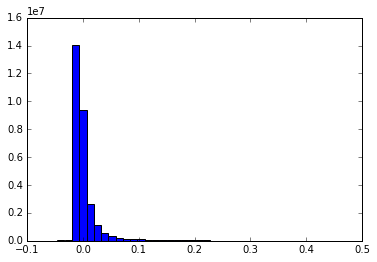

In [52]:
plt.hist(attention, bins=40);

In [53]:
compute_auc_with_attention(data, track_proba=dt.predict_proba(data2.to_pandas()), 
                           track_attention=attention - 1.5
                           )

KFold prediction using folds column


0.66199750556606518

In [54]:
compute_auc_with_attention(data, track_proba=dt.predict_proba(data2.to_pandas()), 
                           track_attention=compute_weights(data, attention) - 2
                           )

KFold prediction using folds column


0.66273768778635234

In [55]:
compute_auc_with_attention(data, track_proba=dt.predict_proba(data2.to_pandas()), track_attention=attention * 0 - 3)

KFold prediction using folds column


0.66267978988955112

In [56]:
compute_auc_with_attention(data[:10**6], 
                           track_proba=dt.predict_proba(data2.to_pandas())[:10 ** 6], 
                           track_attention=attention[:10 ** 6] * 0 - 3)

KFold prediction using folds column


0.66032964554767171

# Идея: dropout_loss

лосс-функция по типу exploss для тренировки обычного классификатора.

- оптимальным всегда оказывался вариант с p=0 
    - на 3 миллионах выиграл у всего остального
- назначение весов (равномерных) почему-то не такое, как везде

In [12]:
from sklearn.base import BaseEstimator
class DropoutLoss(BaseEstimator):
    def __init__(self, p=0.0):
        self.p = p

    def fit(self, X, y, sample_weight=None):
        self.sample_weight = numpy.require(sample_weight, dtype='float32') 
        self.y_signed = numpy.require(2 * y - 1, dtype='float32')
        
        _, first_positions, self.event_indices = numpy.unique(X['group_column'].values, return_index=True, return_inverse=True)
        # self.b_signs = numpy.array(X['signB'].values)[first_positions]
        # track_z = - w(track) * sign(track) * sign(B)
        self.track_z = - self.sample_weight * self.y_signed
        
        self.event_losses = numpy.ones(len(first_positions))
        
        # just in case 
        self.sample_weight **= 0.0
        
        return self

    def prepare_tree_params(self, pred):
        # normally, prediction is weight1 * pred1 * sign1 + weight2 * pred2 * sign2 ...
        # loss is exp( - isloss * decision)
        # in case of dropout
        track_exponents = numpy.exp(pred * self.track_z)
        track_multipliers = self.p + (1 - self.p) * track_exponents
        self.event_losses[:] = 1
        numpy.multiply.at(self.event_losses, self.event_indices, track_multipliers)
        grad = - self.event_losses[self.event_indices] / track_multipliers * track_exponents * self.track_z
        
        return grad, self.sample_weight

In [58]:
# x = numpy.bincount(data['group_column'], weights=logit(_p[:, 1]) * (2 * data['label'] - 1) )

In [59]:
# plt.hist(x, range=[-2, 2], bins=21);

In [60]:
for p in [0.0]:
    _dropout_dt = DecisionTrainClassifier(loss=DropoutLoss(p=p), n_estimators=1000, 
                                          learning_rate=0.03, n_threads=16, train_features=features)
    _features = features + ['group_column']
    dt_dropout = FoldingGroupClassifier(_dropout_dt, n_folds=2, group_feature='group_column', train_features=_features)
    dt_dropout.fit(data[_features].to_pandas(), data['label'])
    print None
    for i, _p in enumerate(dt_dropout.staged_predict_proba(data.to_pandas()), 1):
        if i % 2 == 0:
            print compute_auc_with_attention(data, track_proba=_p, track_attention=numpy.zeros(len(data)) - 2),
    print p

None
KFold prediction using folds column
0.635161136287 0.658377172378 0.663936039235 0.665960318105 0.666877294068 -0.1
None
KFold prediction using folds column
0.636615909766 0.65919663933 0.664267018983 0.66611973827 0.667091338142 0.0
None
KFold prediction using folds column
0.63799787623 0.659486301935 0.664300595436 0.666120291879 0.667045452773 0.1
None
KFold prediction using folds column
0.610217993953 0.636684892954 0.64743116016 0.651641956678 0.653798197951 -0.1
None
KFold prediction using folds column
0.610174493123 0.636754846124 0.647443622341 0.651526328129 0.653749644457 0.0
None
KFold prediction using folds column
0.610405353867 0.636824226617 0.647576410593 0.651747492804 0.653873407736 0.1


## Проверка на AdaLoss

вдруг оно и просто так работает?

In [ ]:
from hep_ml.losses import AdaLossFunction

In [ ]:
_base_ada = DecisionTrainClassifier(loss=AdaLossFunction(), n_estimators=2000, 
                                   learning_rate=0.06, n_threads=16, train_features=features)
dt_exploss = FoldingGroupClassifier(_base_ada, n_folds=2, group_feature='group_column', train_features=features + ['group_column'])
_ = dt_exploss.fit(data[features + ['group_column']].to_pandas(), data['label'], 
                   sample_weight=compute_weights(data, numpy.zeros(len(data)) - 2. ) )

In [ ]:
for i, _p in enumerate(dt_exploss.staged_predict_proba(data.to_pandas()), 1):
    if i % 3 == 0:
        print compute_auc_with_attention(data, track_proba=_p, track_attention=numpy.zeros(len(data)) - 2)

In [ ]:
from scipy.special import logit, expit

print compute_auc_with_attention(data, track_proba=expit(logit(_p)) , track_attention=numpy.zeros(len(data)) - 2)
print compute_auc_with_attention(data, track_proba=expit(logit(_p) * 2.) , track_attention=numpy.zeros(len(data)) - 2)
print compute_auc_with_attention(data, track_proba=expit(logit(_p) * 0.5) , track_attention=numpy.zeros(len(data)) - 2)

## GroupLogLoss

требуется сравнить с ExpLoss

In [13]:
from sklearn.base import BaseEstimator
class GroupLogLoss(BaseEstimator):
    def __init__(self):
        pass

    def fit(self, X, y, sample_weight=None):
        self.sample_weight = numpy.require(sample_weight, dtype='float32')
        self.y_signed = numpy.require(2 * y - 1, dtype='float32')
        
        _, first_positions, self.event_indices = numpy.unique(X['group_column'].values, 
                                                              return_index=True, return_inverse=True)
        self.track_z = - self.sample_weight * self.y_signed
        d = T.vector()
        d_b = bincount(self.event_indices, weights=self.track_z * d)
        self.Loss = T.sum(T.nnet.softplus(d_b)) * 2
        self.grad = theano.function([d], -T.grad(self.Loss, d))
        return self

    def prepare_tree_params(self, pred):
        return self.grad(pred), self.sample_weight

In [17]:
_base_dt_log = DecisionTrainClassifier(loss=GroupLogLoss(), n_estimators=2000, 
                                       learning_rate=0.05, n_threads=len(features), train_features=features)
dt_logloss = FoldingGroupClassifier(_base_dt_log, n_folds=2, group_feature='group_column', 
                                    train_features=features + ['group_column'])

_ = dt_logloss.fit(data[features + ['group_column']].to_pandas(), data['label'], 
#                    sample_weight=compute_weights(data, numpy.zeros(len(data)) - 2. ) 
                  )

In [18]:
for i, _p in enumerate(dt_logloss.staged_predict_proba(data.to_pandas()), 1):
    if i % 1 == 0:
        print compute_auc_with_attention(data, track_proba=_p, track_attention=numpy.zeros(len(data)) - 2)

KFold prediction using folds column
0.598972140837
0.619825794458
0.638208229708
0.649180258034
0.65518004934
0.658841436115
0.661151485349
0.662837189058
0.664041256527
0.664855213926
0.665501497501
0.666057203555
0.666498396829
0.666853495154
0.667119081171
0.667394152907
0.667537496838
0.66764924179
0.667723081574
0.667794033835


In [ ]:
assert 0 == 1

In [ ]:
# фильтрация ничего не дала
# _n_tracks = numpy.bincount(data['group_column'])[data['group_column']] 
# _weights = (_n_tracks > 5) & (_n_tracks < 40)
# dt_logloss_filtered = FoldingGroupClassifier(_base_dt_log, n_folds=2, group_feature='group_column', 
#                                     train_features=features + ['group_column'])

# _ = dt_logloss_filtered.fit(data[features + ['group_column']].to_pandas(), data['label'], 
#                             sample_weight=_weights)

In [ ]:
# for i, _p in enumerate(dt_logloss_filtered.staged_predict_proba(data.to_pandas()), 1):
#     if i % 2 == 0:
#         print compute_auc_with_attention(data, track_proba=_p, track_attention=numpy.zeros(len(data)) - 2)

## (Концепция) одновременного обучения бустингов

In [ ]:
# два лосса. Дообучили один - переобучили второй и обратно
# требует метода "дообучи"

# Вначале просто запускаем нейросеть

In [ ]:
from hep_ml.nnet import MLPClassifier

In [ ]:
nn2 = FoldingGroupClassifier(MLPClassifier(layers=[30, 20], epochs=500, scaler='iron'), n_folds=2, group_feature='group_column')
nn2.fit(data[features + ['group_column']].to_pandas(), data['label'], sample_weight=weights);

In [ ]:
track_proba = nn2.predict_proba(data.to_pandas())
predictions = numpy.bincount(data['group_column'], weights=logit(track_proba[:, 1]) * data['signTrack'] )
roc_auc_score(B_signs, predictions)

## Для сравнения возьмем простой MLP из keras

In [ ]:
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from keras.optimizers import RMSprop

In [ ]:
# train-test splitting macnually

N = len(data) // 2

train = data[data['group_column'] < numpy.median(data['group_column'])]
test = data[data['group_column'] >= numpy.median(data['group_column'])]
_, test['group_column'] = numpy.unique(test['group_column'], return_inverse=True)
_, train['group_column'] = numpy.unique(train['group_column'], return_inverse=True)
B_signs_test = test.group_by('group_column')['signB'].groups.aggregate(numpy.mean)

In [ ]:
model = Sequential()
model.add(BatchNormalization(input_shape=(len(features),)))
model.add(Dense(200, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(200, activation='tanh'))
model.add(Dropout(0.2))
model.add(Dense(2, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(lr=1e-4),
              metrics=['accuracy', ])

for _ in range(7):
    model.fit(
        train[features].to_pandas().values, 
        to_categorical(train['label']), 
        nb_epoch=1, verbose=2, 
        validation_data=[test[features].to_pandas().values, to_categorical(test['label'])]
    )
    
    track_proba = model.predict_proba(test[features].to_pandas().values, verbose=2)
    predictions = numpy.bincount(test['group_column'], 
                                 weights=(logit(track_proba[:, 1]) * test['signTrack']))
    print roc_auc_score(B_signs_test, predictions)
    

# Выводы про нейросетки

не особенно тянут. Выше 0.612 не получилось ни с теми, ни с другими.

После iron transform получилось 0.622

## TODO хотелось бы одновременно обучать две нейросетки

In [ ]:
from hep_ml.nnet import MLPClassifier, MLPBase, AbstractNeuralNetworkBase

In [ ]:
AbstractNeuralNetworkBase??

In [ ]:
def prepare(self):
    activation = lambda x: x
    for i, layer in list(enumerate(self.layers_))[1:]:
        W = self._create_matrix_parameter('W' + str(i), self.layers_[i - 1], self.layers_[i])
        # act=activation and W_=W are tricks to avoid lambda-capturing
        if i == 1:
            activation = lambda x, act=activation, W_=W: T.dot(act(x), W_)
        else:
            activation = lambda x, act=activation, W_=W: T.dot(T.tanh(act(x)), W_)

    return activation